### PROBLEM DESCRIPTION

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### FEATURES

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- da_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

#### CLASSIFICATION

The labels in this dataset are simple. There are three possible values:

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

In [93]:
### RELEVANT LIBRARIES

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
from scipy import stats

### DATA READING

##### First we read the provided datasets, using the id field as an index. Since the training labels (classifications) and independent variables are separated, the train_set will be the combination of the two. 
##### The test set is read as given, with the id column as the index.

In [94]:
file_path = '~/Google Drive/Group D/Machine Learning II/Group_Final/'

train_data = pd.read_csv(os.path.join(file_path, 'train_set.csv'), index_col = 'id', parse_dates=True)  # only contains the independent variables
train_labels = pd.read_csv(os.path.join(file_path, 'train_labels.csv'), index_col = 'id')  # only contains the dependent variable

train_set = train_data.merge(train_labels, left_index = True, right_index = True)  # combine the labels and independent variables

test_set = pd.read_csv(os.path.join(file_path, 'test_set.csv'), index_col = 'id', parse_dates=True) # test set 

### COMBINING

##### We combine the test and train sets so that all the features we create will be present in both datasets. 
##### In order to have the same dimentions, a label column on the test_set is created and the values are set to zero.

In [95]:
test_set['status_group'] = 0

dataset = pd.concat([train_set,test_set], axis =0)

### DESCRIPTIVE STATISTICS

We start our analysis by looking at some simple descriptive statistics.

In [96]:
# target variable count shows that there is a significant class imbalance problem with our target variable that needs to be dealt with

dataset['status_group'].value_counts()

functional                 32259
non functional             22824
0                          14850
functional needs repair     4317
Name: status_group, dtype: int64

In [97]:
# simple descriptive statistics

dataset.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 69572 to 68707
Data columns (total 40 columns):
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
recorded_by              74250 non-null obj

**Points to note**

- Not many columns with null-values
- funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit have NULL values
- of the ones with nulls, scheme_name has the highest (half) NULL values. This should be taken into account first

In [98]:
# simple skewness check

dataset.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


**Points to note**

- The median for the amount_tsh, num_private and population is low (or zero) compared to the standard deviation, indicating these have high skewness
- The rest of the numeric columns are either related to location or years so descriptive statistics would not necessarily apply in this case.
- In the case of population, the mean is zero, which we need to take into account
- There are variables where the construction year is zero, we need to take this into account

In [99]:
# unique values

dataset.nunique()

amount_tsh                 102
date_recorded              369
funder                    2140
gps_height                2456
installer                 2410
longitude                71870
latitude                 71869
wpt_name                 45684
num_private                 68
basin                        9
subvillage               21425
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2098
population                1128
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2868
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

**Points to note**

- The region_code and region should refer to the same thing but the unique valeus are not the same. If 80% of the dataset has the same regions for each region_code, perhaps the region can be removed. 
- The recorded_by has only 1 unique value. Besides, its only the group that entered the data so might have little relevance. This column can be removed.


### EDA - PHASE I

For the intial EDA, we used the Pandas Profiling library. Some of the key points to note from this overview were:

- There are only 1.9% missing values. However, there are other fields (construction_year, gps_height) that have zeros (in addition to the population field we discovered above) which might need some form of imputation. 
- The profiling confirms our hypothesis above that some variables (such as amount_tsh) are highly skewed. We would have to take this into consideration of a dimentionality reduction technique (such as PCA) is to be used. 
- The profiling also confirms that we have some variables with very high cardinality. Having large amounts of categorical variables with distinct values immediately increases our problems with the curse of dimentionality.

In [100]:
pandas_profiling.ProfileReport(dataset)

Number of variables,41
Number of observations,74250
Total Missing (%),1.9%
Total size in memory,23.2 MiB
Average record size in memory,328.0 B
Numeric,10
Categorical,30
Boolean,0
Date,0
Text (Unique),0
Rejected,1


### EDA - PHASE II

In Phase II of our EDA, we carried out some visual exploration of our data. Some key points to note are:

- When looking at the scatterplot of waterpoints around the country, we note that there is a large cluster of non-functional waterpoints towards the west of the country while there is a clustr of functioning waterpoints towards the east. This needs to be taken into account during the feature selection process. 
- Newer pumps are largely functional (with some outliers) while non-functional and those that need repair are older, which is logical. 
- The quality of water in the pumps do vary by construction_year. This might be a good way to impute the variables that are zero in the construction_year. 
- amount_tsh has some obvious outliers, which need to be dealth with either through deletion or my reducing the skewness through scaling. 
- In addition, some dry waterpoints have enourmous quanities of available water (amount_tsh). We found that those that have dry in the quantity field are also non-functional. This seems to indicate that there might be some data-leakeage: quantity is a variable that is update after the pump is deemed non-functional and as such, this varible should probably be delted. 

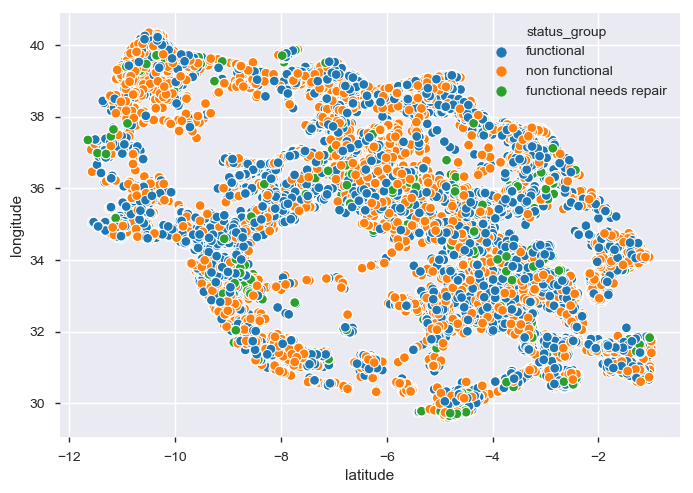

In [101]:
train_set_nout = train_set[train_set['longitude']!=0] #there is one with zero longitude
sns.scatterplot(x=train_set_nout['latitude'],y=train_set_nout['longitude'], hue=train_set_nout['status_group'])

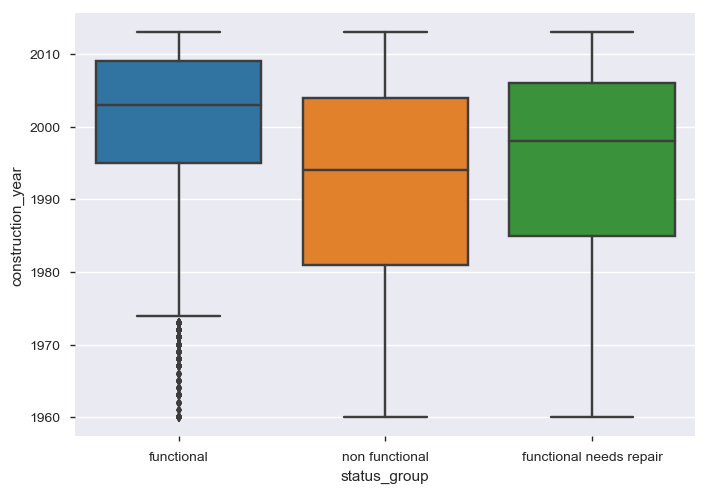

In [102]:
train_set_year = train_set[train_set['construction_year']!=0]
sns.boxplot(y=train_set_year['construction_year'], x=train_set_year['status_group'])

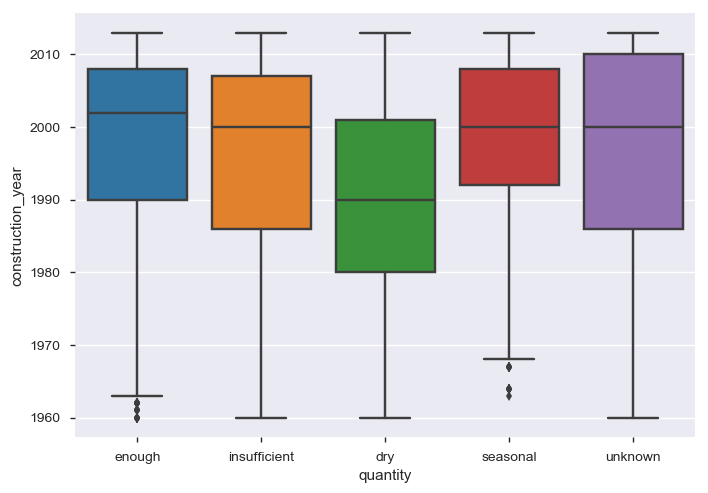

In [103]:
train_set_year = train_set[train_set['construction_year']!=0]
sns.boxplot(y=train_set_year['construction_year'], x=train_set_year['quantity'])

In [104]:
train_set[train_set['construction_year']==0]['status_group'].value_counts()

functional                 10555
non functional              8365
functional needs repair     1789
Name: status_group, dtype: int64

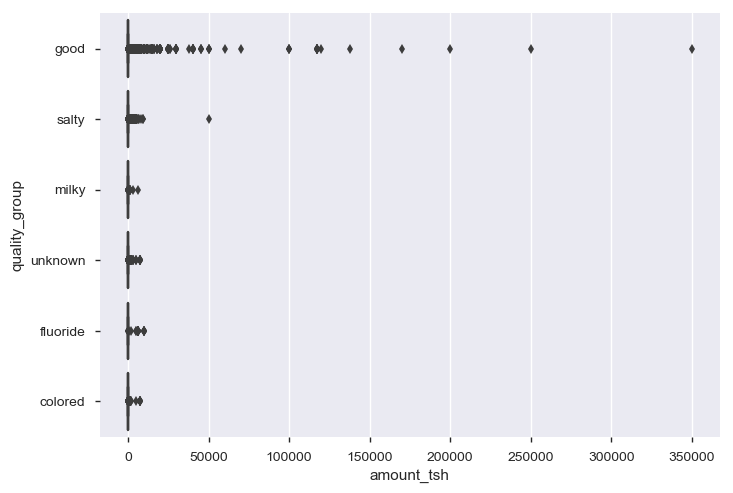

In [105]:
sns.boxplot(y=train_set['quality_group'], x=train_set['amount_tsh'])

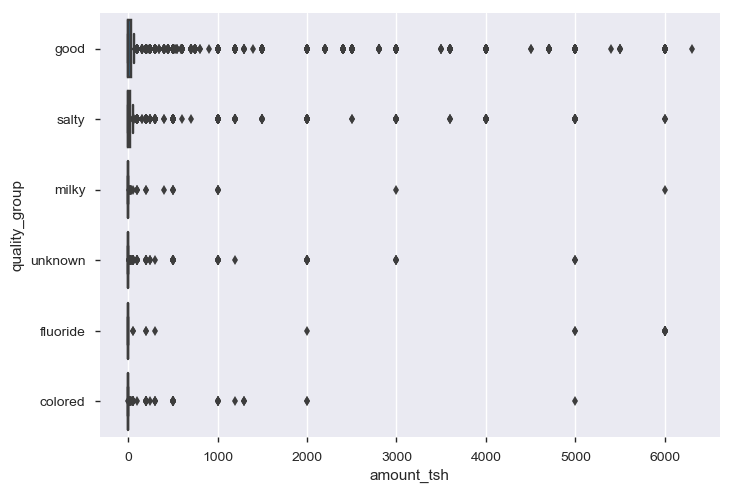

In [106]:
train_set_noout = train_set[np.abs(stats.zscore(train_set['amount_tsh'])) < 2] #without outliers

sns.boxplot(y=train_set_noout['quality_group'], x=train_set_noout['amount_tsh']) #without outliers

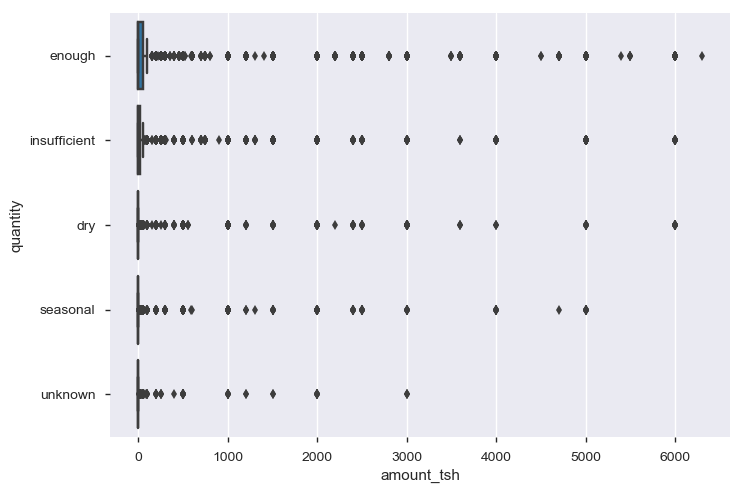

In [107]:
sns.boxplot(y=train_set_noout['quantity'], x=train_set_noout['amount_tsh']) #without outliers

### EDA - PHASE II

- Once we had analysed the numerical columns, we moved on towards finding redundant columns. Since most of our columns are categorical, we approached the problem by checking if some columns had the same values. If 80% of the fields matched, we would remove the variable. 
- In addition, we noticed that in some cases, there were variables that are *almost* the same values. For example, payment would have a variable called 'pay annual' and payment type would be the same without 'pay'. In cases like these, we removed one of the variables by keeping the one with more unique values for more variability.

In [108]:
# check if payment and payment type is the same.
# <58% are exactly the same. Those that are not similar are because they have the 'pay' letter on them. We should remove.

print((dataset['payment'].str.lower() == dataset['payment_type'].str.lower()).mean())

dataset = dataset.drop(['payment'], axis=1)

0.5814814814814815


In [109]:
# check if extraction type is the same.
# <80% are the same in some cases but it seems like one is a breakdown (subgroup of another). 
# extraction_type and gorup are 95% the same, so one can be removed
# extraction type is a breakdown of extraction_type class. To reduce the dimentions, we remove extraction_type, which is a breakdown of
# extraction type class.

train_set['extraction_type'].unique()
train_set['extraction_type_class'].unique()

print((dataset['extraction_type'].str.lower() == dataset['extraction_type_class'].str.lower()).mean())
print((dataset['extraction_type_class'].str.lower() == dataset['extraction_type_group'].str.lower()).mean())
print((dataset['extraction_type'].str.lower() == dataset['extraction_type_group'].str.lower()).mean())


dataset = dataset.drop(['extraction_type','extraction_type_group'],axis=1)

0.6376700336700337
0.6715286195286195
0.9581144781144781


In [110]:
# check if management type is the same.
# <5% are the same
# both need to be kept

train_set.groupby(['management','management_group'])['status_group'].count().unstack('management_group')

print((dataset['management'].str.lower() == dataset['management_group'].str.lower()).mean())

0.05380471380471381


In [111]:
# check if quaility type is the same.
# 13% are the same but that is because water_quality is a subgroup of quality_group. To reduce dimentions, we remove water quality. 

train_set.groupby(['water_quality','quality_group'])['status_group'].count().unstack('quality_group')

print((dataset['water_quality'].str.lower() == dataset['quality_group'].str.lower()).mean())

dataset = dataset.drop('quality_group',axis=1)

0.1303164983164983


In [112]:
# check if source type is the same.
# <80% are the same but source is a subgroup of source_type. To reduce dimentions, we remove source. 

train_set.groupby(['source','source_type'])['status_group'].count().unstack('source_type')

print((dataset['source'].str.lower() == dataset['source_type'].str.lower()).mean())

dataset = dataset.drop('source',axis=1)

0.6238383838383839


In [113]:
# check if the funder and installer are the same
# <80% are the same
# both need to be kept

print((dataset['funder'].str.lower() == dataset['installer'].str.lower()).mean())

0.31907070707070706


In [114]:
# check if quality type is the same.
# 100% are the same
# One of them can be removed

print((dataset['quantity'].str.lower() == dataset['quantity_group'].str.lower()).mean())

dataset = dataset.drop('quantity_group', axis=1)

1.0


In [115]:
# check if quaility type is the same.
# 89% are the same
# Worth removing in this case

print((dataset['waterpoint_type'].str.lower() == dataset['waterpoint_type_group'].str.lower()).mean())

dataset = dataset.drop('waterpoint_type_group', axis=1)

0.8974949494949495


In [116]:
# Check if scheme_management is the same as management
# in this case 83% of the time the management and scheme management is the same
# we can remove one of them. 
# Since there are no missing values in management, scheme_management is removed

print((dataset['management'].str.lower() == dataset['scheme_management'].str.lower()).mean())

dataset = dataset.drop('scheme_management', axis=1)
dataset = dataset.drop('management',axis=1)

0.8302356902356902


### NULL & ZERO VALUES

- For NULL values, since there are very few columns with NULL values, we can impute the values one by one.
- For "pure" NULL values in categorical varibles, we impute the values using the mode of that variable. For example, for the funder, we use the funder that is most active. 
- For zero values, we impute either using the strategies discussed in the EDA sections or use a custom method which is described in the comments above each imputation.

In [117]:
# funder refers to who funded the project. In this case, a mode, which tells us the entity most involved in funding the projects, 
# can be used for imputting. 

dataset['funder'] = dataset['funder'].str.lower()

print(dataset['funder'].mode()) # The government of Tanzania is the largest funder

dataset['funder'] = dataset['funder'].fillna(value='government of tanzania')
dataset['funder'] = dataset['funder'].replace(to_replace='0',value='government of tanzania')

0    government of tanzania
dtype: object


In [118]:
# installer refers to the organization that installed the wells. In this case, a mode, which tells us the entity most involved in 
# installations, can be used for imputting. 

dataset['installer'] = dataset['installer'].str.lower()

print(dataset['installer'].mode()) # DWE is the largest installer

dataset['installer'] = dataset['installer'].fillna(value='dwe')
dataset['installer'] = dataset['installer'].replace(to_replace='0',value='dwe')

0    dwe
dtype: object


In [119]:
# the subvillage is filled by the mode of the corresponding ward i.e the most often occuring 
# subvillage in each ward

dataset['subvillage'] = dataset['subvillage'].str.lower()

dataset['subvillage'] = dataset.groupby(['district_code'])['subvillage'].transform(lambda x: x.fillna(x.mode()))
dataset['subvillage'] = dataset.groupby(['district_code'])['subvillage'].transform(lambda x: x.replace('0',x.mode()))

In [120]:
## if a public meeting is required for a permit to be give, then perhaps we can infer using the permit column?
## in only 66% of the cases the two match so we cannot use the permit column to fill in the public meeting column

(dataset.loc[dataset[dataset['public_meeting'].notnull()].index, 
            'public_meeting'] == dataset.loc[dataset[dataset['public_meeting'].notnull()].index, 
                                             'permit']).mean()

0.6625722234110849

In [121]:
# we impute the 0 values for construction year using quantity groups. The reason was discussed in the EDA. 

dataset['construction_year'] = dataset.groupby(['quantity'])['construction_year'].transform(lambda x: x.replace(0,x.median()))  

In [122]:
# we impute the 0 values for population using the median population for each district.
# Since going lower down in the geographical hierarchy might give us very small values, we decided to use the district as the best proxy

dataset['population'] = dataset.groupby(['ward'])['population'].transform(lambda x: x.replace(0,x.median()))  

### IRRELEVANT COLUMNS

Once we finished the EDA and imputation, we realised some fields were irrelevant for the project:

- The date of data entry is irrelevant to predict the functioning of a water point. 
- The name of a waterpoint should not impact its functioning. Besides each point should have its own name so this will be an all unique variable that should not have a bearing on functionality.
- The recorded by column has only 1 unique value, it refers to the group entering the data.
- The company operating the scheme should be scrutinized rather than the scheme name. Besides each name should refer to only a single scheme so this will be an all unique variable that should not have a bearing on functionality.
- num_private: we have no information about this variable.

In [123]:
# we deemed the following columns to be irrelevant 

dataset = dataset.drop('wpt_name',axis =1)  
dataset = dataset.drop('recorded_by', axis=1) 
dataset = dataset.drop('scheme_name', axis=1)
dataset = dataset.drop('num_private',axis=1)

## FEATURE ENGINEERING

Before we move onto the final feature selection, we decided to create some features using the varibles we have available. These were:

- gps_height: The GPS height refers to the height of the waterpoint above sea level. We understand that the height is an important variable in this domain as the deeper a well is the more complex it is to build a well functioning pump. However since the height is a numerical variable but its implications are categorical, we had to find a way to categorize the variable. We decided to group the heights by quartile,and create four categorical varibales that determined whether the well was below sea level (assumign sea_level as 0) or above (and my how much).
- latitude/longitude: As we saw on the latitude/longitude scatterplot that there was a difference in area and functioning, we decided to divide the country into four sub-regions (northwest/northeast/southwest/southeast) using the latitude and longitude. 
- operational_year: This was a new variable we created referencing a post we found online. It calcualtes the number of years a pump has been active using the date recorded and the construction year.The operational_year is in reality a categorical variable. However, if we were to dummify it, we would have an additional 55 unique columns. If we did not, we would end up with very high values which might confuse the model. The way we saw fit to deal with this is to min/max normalize the construction year so that it goes from 0-1 with 0 being the oldest and 1 being the newest. 
- construction_year: The construction year is in reality a categorical variable. However, if we were to dummify it, we would have an additional 55 unique columns. If we did not, we would end up with very high values which might confuse the model. The way we saw fit to deal with this is to min/max normalize the construction year so that it goes from 0-1 with 0 being the oldest and 1 being the newest. 
- dist: This feature was created using the longitude and latitude. It is essentially the distance from each pump to the capital of Tanzania. We did this assuming that the distance (and not just the area) might have an impact on the funcioning. 
- qual/quan: This is a combined feature of quality and quantity, which we thought better reflected the variables. 
- top funder/installer: To reduce the dimentionality of the funders and installers, we tried to group the variables in each column. To do so, we wrote functions that would the names of the most active funders and installers (those with over 500 fundings/installations) and the rest would be categorised as 'others'.

In [124]:
## change the gps height to a categorical variable signifying how much distance it has from the sea level

below_sea = dataset['gps_height'].quantile(0.25)
median_height= dataset['gps_height'].quantile(0.5)
slightly_above = dataset['gps_height'].quantile(0.75)

def gps_change(height):
    if height <= below_sea:
        return "below_sea"
    elif height > below_sea and height <= median_height:
        return "median_height"
    elif height > median_height and height <= slightly_above:
        return "slightly_above"
    elif height > slightly_above:
        return "high"
    
dataset['gps_height']=dataset['gps_height'].map(gps_change)

In [125]:

import datetime

dataset['year_recorded'] = pd.DatetimeIndex(dataset['date_recorded']).year

dataset = dataset.drop('date_recorded', axis =1)

In [126]:
op_years = list(dataset['year_recorded']-dataset['construction_year'])
operational_years = []
for i in op_years:
    if (i > 500) or (i < 0):
        operational_years.append(0)
    else:
        operational_years.append(i)

dataset['operational_years'] = operational_years

dataset = dataset.drop('year_recorded', axis=1)

In [127]:
#min/max for years

dataset['operational_years'] = dataset.groupby(['quantity'])['operational_years'].transform(lambda x: x.replace(0,x.median()))  

min_year = dataset['operational_years'].min()
max_year = dataset['operational_years'].max()

dataset['operational_years'] = ((dataset['operational_years'] - min_year) / (max_year - min_year))

In [128]:
#min/max for years

min_year = dataset['construction_year'].min()
max_year = dataset['construction_year'].max()

dataset['construction_year'] = ((dataset['construction_year'] - min_year) / (max_year - min_year))

In [129]:
# define a dictionary of the funder name with its count
# loop over the dictionary to append only those with counts over 500
# append found names to a list

funder_counts = dataset['funder'].value_counts() 
funder_dictionary = funder_counts.to_dict() #converts to dictionary

top_funders = []

for key, value in funder_dictionary.items():
        if value > 500:
            top_funders.append(key)

In [130]:
# define a function that loops over the top funders list above and returns either the funder name or 'other'
# use the function within a map to rename the funder column

def funder_change(funder):
    if funder in top_funders:
        return funder
    else:
        return 'other'
    
dataset['funder']=dataset['funder'].map(funder_change)

In [131]:
# define a dictionary of the intaller name with its count
# loop over the dictionary to append only those with counts over 500
# append found names to a list

installer_counts = dataset['installer'].value_counts() 
installer_dictionary = installer_counts.to_dict() #converts to dictionary

top_installers = []

for key, value in installer_dictionary.items():
        if value > 500:
            top_installers.append(key)

In [132]:
# define a function that loops over the top funders list above and returns either the funder name or 'other'
# use the function within a map to rename the installer column

def installer_change(installer):
    if installer in top_installers:
        return installer
    else:
        return 'other'
    
dataset['installer']=dataset['installer'].map(installer_change)

In [133]:
# the combination of quality and quantity.


dataset['quality_quan'] = dataset['water_quality'] + '_' + dataset['quantity']

dataset = dataset.drop(['water_quality','quantity'], axis=1)

In [137]:
# define latitude and longitude distance funciton


import pyproj
from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84')

#Get distance between pairs of lat-lon points
def Distance(lon1,lat1,lon2,lat2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
    return dist

#Create test data
latC = np.ones(74250)*36.04196
lonC = np.ones(74250)*-5.940758


#Add/update a column to the data frame with the distances (in metres)
dataset['dist'] = Distance(dataset['longitude'].tolist(),dataset['latitude'].tolist(),lonC.tolist(),latC.tolist())

In [138]:
# divide country into north, south

country_half = dataset['longitude'].mean()

def longitude_change(longitude):
    if longitude < country_half:
        return "south"
    elif longitude > country_half:
        return "north"    
    
dataset['longitude']=dataset['longitude'].map(longitude_change)

In [139]:
# divide country into east and west

country_middle = dataset['latitude'].mean()

def latitude_change(latitude):
    if latitude < country_half:
        return "west"
    elif latitude > country_half:
        return "east"    
    
dataset['latitude']=dataset['latitude'].map(latitude_change)

In [140]:
# create an area that is the combination of the new latitudes and longitudes

dataset['area']=dataset['longitude'] + dataset['latitude']

In [141]:
dataset = dataset.drop(['latitude', 'longitude'], axis =1)

## FEATURE SELECTION

Finally, we had to select the final variables for modelling. In this step:

- We decided to remove some varibles with the sole purpose of reducing the cardinality of our dataset. For example, the ward variable has 20000+ unique categorical values. This would mean 20000 additional columns after dummification.
- Since we had created geographical groups based on latitude and longitude, we also deemed the other, more granular variables, like district code unnecessary. We therefore decided to remove these variables from our intial model. 
- We had carried out a Chi2 test to select the 100 most important variables for our dataset. We had tried a PCA but it gave us worse results that using a simple Chi2 with the remaining variables. We realised this was because the final features we had selected were uncorrelated so the PCA had no impact. After carrying out some more feature engineering, we were able to manually reduce the dimentions, so then we decided to remove the chi2 test from the process. The code for the process is provided in the appendix.

In [142]:
from sklearn.preprocessing import StandardScaler

In [143]:
sc = StandardScaler()

In [144]:
#drop the variables with high cardinality

dataset = dataset.drop(['region','region_code', 'district_code', 'ward','subvillage','lga'], axis=1)

In [146]:
# scale the two remaining highly skewed columns

scaled_dataset = pd.DataFrame(sc.fit_transform(dataset[['dist','amount_tsh','population']]), columns=['dist','amount_tsh','population'], index=dataset.index)

In [147]:
# merge the remaining columns

dataset_pop_am = pd.merge(dataset.drop(['dist','amount_tsh','population'], axis=1),scaled_dataset, left_index=True, right_index=True)

In [148]:
# Dummy the variables

dummy_dataset = pd.get_dummies(dataset_pop_am.drop('status_group', axis=1))

In [149]:
# finally merge the target variables with all the dummy ones

selected = pd.merge(dataset['status_group'],dummy_dataset, left_index=True, right_index=True)

In [150]:
selected.head()

,status_group,construction_year,operational_years,dist,amount_tsh,population,funder_adb,funder_amref,funder_danida,funder_dhv,...,quality_quan_soft_insufficient,quality_quan_soft_seasonal,quality_quan_soft_unknown,quality_quan_unknown_dry,quality_quan_unknown_enough,quality_quan_unknown_insufficient,quality_quan_unknown_seasonal,quality_quan_unknown_unknown,area_northwest,area_southwest
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,0.993045,0.226415,0.762086,1.954529,-0.155494,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8776,functional,0.998510,0.056604,-0.542596,-0.109637,0.206613,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
34310,functional,0.998013,0.075472,0.116819,-0.101036,0.143085,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
67743,non functional,0.986587,0.509434,1.447207,-0.109637,-0.263490,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19728,functional,0.000000,0.000000,-1.086651,-0.109637,-0.386310,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## TEST & TRAIN SET

Once we had the list of variables from the chi-squared, the final step before modelling was to separate the test and train sets. We also specified a seed and divided the train and validation sets. 

In [151]:
train_set_final = selected.loc[selected['status_group']!=0]
test_set_final = selected.loc[selected['status_group']==0] #get the test_set

In [152]:
train_set_final.shape

(59400, 141)

In [153]:
test_set_final.shape

(14850, 141)

In [154]:
from sklearn.model_selection import train_test_split

In [155]:
np.random.seed(42)

In [156]:
X = train_set_final.drop('status_group', axis=1).values
y = train_set_final['status_group'].values

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## MODELLING

For the modelling phase, we tried various algorithms:
- A BalancedBagging classifier which would subsample the majority classes
- An XGBoost classifier
- Two SVMs: one with a Gaussian kernel and another with a linear kernel
- An ExtraTree Classifier
- A Random forest

In the end, the Random Forest with Hyperparameter tuning gave us the best results, which is the model we present below. Some of the other models have been included in the Appendix section of this document. 

In [158]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [159]:
# set the random forest with some hyperparameter optimisation


param_grid = {
    'n_estimators': [5, 200],
    'max_features': ['auto','sqrt', 'log2']
}

random_f = RandomForestClassifier()

final = RandomizedSearchCV(estimator=random_f,param_distributions = param_grid,cv=10)

**Please note it takes at least 15 minutes to run the code**

In [160]:
# fitStandardScaler tuned model from the random search

final.fit(X_train,y_train)

C:\Users\anups\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [161]:
# verify best parameters

final.best_params_

{'n_estimators': 200, 'max_features': 'auto'}

In [162]:
# use the model to predict on the validation set

y_pred = final.predict(X_test)

In [163]:
from sklearn.metrics import accuracy_score

In [164]:
# accuracy_score

accuracy_score(y_test,y_pred)

0.7852693602693602

In [165]:
# final test_set

test_set = test_set_final.drop('status_group',axis=1)

In [166]:
# predict the classes and set the column and index as required by driven-data

df_predictions = pd.DataFrame(final.predict(test_set))
df_predictions.columns = ['status_group']
df_predictions.index = test_set.index

In [167]:
# write predictions to file

df_predictions.to_csv(os.path.join(file_path, 'predictions.csv'))

## CONCLUSION

We submitted our results to driven data and got a best score of 0.7916, which puts us at a rank of 1650 (submitted under the username 'mabelitagp'). The file generated from this code will likely give a slightly lower score of 0.7907, which ranks 1665 (under the username of 'anups').


In short, we faced a lot of issues with cardinality, which we tried to reduce through feature creation. Even this was a difficult task given spelling and data entry errors.

## Appendix

Code snippets from the different things we tried. 

In [168]:
#from xgboost import XGBClassifier

In [169]:
#model = XGBClassifier(learning_rate=0.01)

In [170]:
#model.fit(X_train, y_train)

In [171]:
#y_pred = model.predict(X_test)

In [172]:
#accuracy_score(y_test,y_pred)

In [173]:
#from sklearn.svm import SVC 
#svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
#svm_predictions = svm_model_linear.predict(X_test) 

In [174]:
#accuracy_score(y_test,svm_predictions)

In [175]:
#from sklearn.svm import SVC
#svclassifier = SVC(kernel='rbf')
#svclassifier.fit(X_train, y_train)

In [176]:
#y_pred = svclassifier.predict(X_test)

In [177]:
#accuracy_score(y_test,y_pred)

In [178]:
#random_f.fit(X_train,y_train)

In [179]:
#y_pred=random_f.predict(X_test)

In [180]:
#accuracy_score(y_test,y_pred)

In [181]:
# predict the house prices and set the column and index as required by kagle
# exp to scale back the predictions to its original form.

#df_predictions = pd.DataFrame(random_f.predict(test_set))
#df_predictions.columns = ['status_group']
#df_predictions.index = test_set.index

In [182]:
#Create an object of the classifier.
#bbc = BalancedBaggingClassifier(base_estimator= RandomForestClassifier(max_features='sqrt'),
#                                sampling_strategy='auto',
 #                               replacement=False,
   #                             random_state=0)

In [183]:
#from imblearn.ensemble import BalancedBaggingClassifier
#from sklearn.ensemble import GradientBoostingClassifier

#Create an object of the classifier.
#bbc = BalancedBaggingClassifier(base_estimator= GradientBoostingClassifier(),
 #                               sampling_strategy='auto',
  #                              replacement=False,
   #                             random_state=0)

In [184]:
#Train the classifier.
#bbc.fit(X_train, y_train)

In [185]:
#y_pred=bbc.predict(X_test)

In [186]:
#from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [187]:
#balanced_accuracy_score(y_test,y_pred)

In [188]:
#cm = confusion_matrix(y_test, y_pred) 

In [189]:
#cm

In [190]:
##our code to select the PCAs that explain over 80% variability

#from sklearn.decomposition import PCA
#for i in range(0,50):
 #   pca = PCA(n_components=i)
  #  principal_componenets  = pd.DataFrame(pca.fit_transform(dataset.drop('status_group', axis=1)))
   # if pca.explained_variance_ratio_.sum()>0.8:
    #    pca = PCA(n_components=i)

In [ ]:
# divide the dataset to have only the ones that have target class labels

#labeled_set = dataset_pre_chi.loc[dataset_pre_chi['status_group']!=0] #set train set 

In [ ]:
# verify no zeros in the target class

#labeled_set['status_group'].value_counts()

In [ ]:
# set the arrays for the chi-squared test

#X_chi = labeled_set.drop('status_group',axis=1).values

#y_chi = labeled_set['status_group'].values

In [ ]:
# SelectKbest helps us select the best values more easily

#from sklearn.feature_selection import SelectKBest

In [ ]:
# Create and fit selector
#selector = SelectKBest(chi2, k=100)
#selector.fit(abs(X_chi),y_chi)
# Get columns to keep
#cols = selector.get_support(indices=True)

In [ ]:
# final dataset

#selected = pd.merge(dataset_pre_chi['status_group'],dataset_pre_chi.iloc[:,cols], left_index=True, right_index=True)